Test script to demonstrate the apply_dynamic_masking function with dummy data.
This script creates synthetic peptide and MHC data and shows the masking behavior.

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

Dynamic Masking Test Script
Creating dummy features...
Original feature shapes:
  pep_blossom62: (1, 15, 23)
  pep_mask: (1, 15)
  mhc_emb: (1, 50, 128)
  mhc_mask: (1, 50)
  pep_ohe_target: (1, 15, 21)
  mhc_ohe_target: (1, 50, 21)
  labels: (1, 1)

Original masks:
  Peptide: 10 valid positions, 5 padded
  MHC: 40 valid positions, 10 padded
  Peptide original padded positions have zero features: True
  MHC original padded positions have zero features: True

Applying random padding before dynamic masking...
  Randomly padded 1 peptide positions.
  Randomly padded 2 MHC positions.

Applying dynamic masking...
  - Masked positions will keep original features but change token to -1.0
  - Dynamically padded positions will have zero features and token -2.0
  - Original padded positions already have zero features and token -2.0

Generating visualization...
MHC dimension-level masking: 543 individual features masked
🟠 Orange squares in MHC plot show dimension-level masking

=== Masking Summar

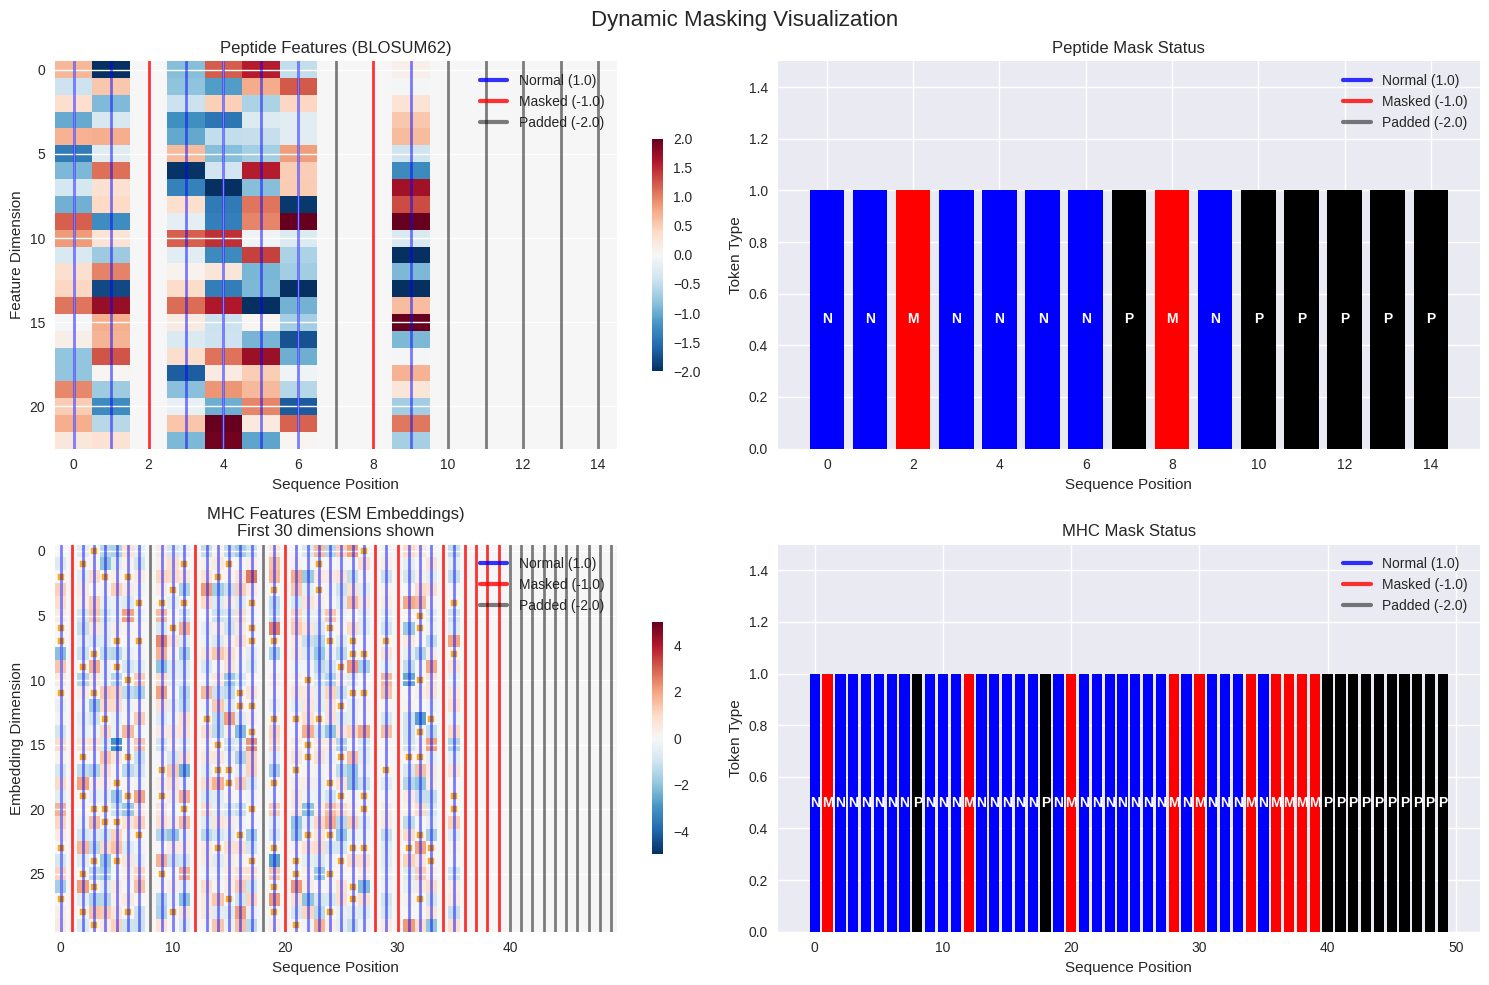

In [20]:
# Define constants that would normally come from utils.py
NORM_TOKEN = 1.0   # Normal/valid token
MASK_TOKEN = -1.0  # Masked token (keep features, just mark as masked)
PAD_TOKEN = -2.0   # Padding token (zero out features)
MASK_VALUE = 0.0   # Value to set masked features to
PAD_VALUE = 0.0    # Value for padding


def apply_dynamic_masking(features, emd_mask_d2=True):  # Added optional flag
    """
    Applies random masking for training augmentation inside the tf.data pipeline.
    This version is corrected to match the original DataGenerator logic.
    """
    # Peptide Masking
    valid_pep_positions = tf.where(tf.equal(features["pep_mask"], NORM_TOKEN))
    num_valid_pep = tf.shape(valid_pep_positions)[0]
    # At least 2 positions, or 15% of the valid sequence length
    num_to_mask_pep = tf.maximum(2, tf.cast(tf.cast(num_valid_pep, tf.float32) * 0.15, tf.int32))
    shuffled_pep_indices = tf.random.shuffle(valid_pep_positions)[:num_to_mask_pep]
    if tf.shape(shuffled_pep_indices)[0] > 0:
        # Update the mask to MASK_TOKEN (-1.0)
        features["pep_mask"] = tf.tensor_scatter_nd_update(features["pep_mask"], shuffled_pep_indices,
                                                           tf.repeat(MASK_TOKEN, num_to_mask_pep))
        # Zero out the feature values for the masked positions
        feat_dtype = features["pep_blossom62"].dtype
        mask_updates_pep = tf.fill([num_to_mask_pep, tf.shape(features["pep_blossom62"])[-1]],
                                   tf.cast(MASK_VALUE, feat_dtype))
        features["pep_blossom62"] = tf.tensor_scatter_nd_update(features["pep_blossom62"], shuffled_pep_indices,
                                                                mask_updates_pep)
    # MHC Masking
    valid_mhc_positions = tf.where(tf.equal(features["mhc_mask"], NORM_TOKEN))
    num_valid_mhc = tf.shape(valid_mhc_positions)[0]
    # At least 5 positions, or 15% of the valid sequence length
    num_to_mask_mhc = tf.maximum(10, tf.cast(tf.cast(num_valid_mhc, tf.float32) * 0.15, tf.int32))
    shuffled_mhc_indices = tf.random.shuffle(valid_mhc_positions)[:num_to_mask_mhc]
    if tf.shape(shuffled_mhc_indices)[0] > 0:
        # Update the mask to MASK_TOKEN (-1.0)
        features["mhc_mask"] = tf.tensor_scatter_nd_update(features["mhc_mask"], shuffled_mhc_indices,
                                                           tf.repeat(MASK_TOKEN, num_to_mask_mhc))
        # Zero out the feature values for the masked positions
        mhc_dtype = features["mhc_emb"].dtype
        mask_updates_mhc = tf.fill([num_to_mask_mhc, tf.shape(features["mhc_emb"])[-1]], tf.cast(MASK_VALUE, mhc_dtype))
        features["mhc_emb"] = tf.tensor_scatter_nd_update(features["mhc_emb"], shuffled_mhc_indices, mask_updates_mhc)
    # This logic was in the original generator but is a distinct augmentation step.
    # It can be enabled if you find it improves model robustness.
    if emd_mask_d2:
        # Find positions that are STILL valid (not padded and not positionally masked)
        remaining_valid_mhc = tf.where(tf.equal(features["mhc_mask"], NORM_TOKEN))
        if tf.shape(remaining_valid_mhc)[0] > 0:
            # Get the embeddings at these remaining valid positions
            valid_embeddings = tf.gather_nd(features["mhc_emb"], remaining_valid_mhc)
            # Create a random mask for the feature dimensions
            dim_mask = tf.random.uniform(shape=tf.shape(valid_embeddings), dtype=features["mhc_emb"].dtype) < tf.cast(
                0.15, features["mhc_emb"].dtype)
            # Apply the mask (multiply by 0 where True, 1 where False)
            masked_embeddings = valid_embeddings * tf.cast(~dim_mask, features["mhc_emb"].dtype)
            # Scatter the modified embeddings back into the original tensor
            features["mhc_emb"] = tf.tensor_scatter_nd_update(features["mhc_emb"], remaining_valid_mhc,
                                                              masked_embeddings)
    return features


def create_dummy_features(pep_len=15, mhc_len=50, blosum_dim=23, mhc_emb_dim=128, batch_size=1):
    """
    Create dummy features that match the expected structure from the training script.
    Padded positions should have zero features, valid positions have random features.
    """
    # Create peptide features - first 10 positions are valid, rest are padded
    pep_blossum62 = tf.random.normal([batch_size, pep_len, blosum_dim], dtype=tf.float32)
    # Zero out the padded positions in features
    pep_pad_mask = tf.concat([
        tf.ones([batch_size, 10, blosum_dim]),  # Keep valid positions
        tf.zeros([batch_size, pep_len - 10, blosum_dim])  # Zero padded positions
    ], axis=1)
    pep_blossum62 = pep_blossum62 * pep_pad_mask

    # Create peptide mask: first 10 positions are valid (NORM_TOKEN), rest are padding (PAD_TOKEN)
    pep_mask = tf.concat([
        tf.fill([batch_size, 10], NORM_TOKEN),
        tf.fill([batch_size, pep_len - 10], PAD_TOKEN)
    ], axis=1)

    # Create MHC embedding features - first 40 positions are valid, rest are padded
    mhc_emb = tf.random.normal([batch_size, mhc_len, mhc_emb_dim], dtype=tf.float32)
    # Zero out the padded positions in features
    mhc_pad_mask = tf.concat([
        tf.ones([batch_size, 40, mhc_emb_dim]),  # Keep valid positions
        tf.zeros([batch_size, mhc_len - 40, mhc_emb_dim])  # Zero padded positions
    ], axis=1)
    mhc_emb = mhc_emb * mhc_pad_mask

    # Create MHC mask: first 40 positions are valid, rest are padding
    mhc_mask = tf.concat([
        tf.fill([batch_size, 40], NORM_TOKEN),
        tf.fill([batch_size, mhc_len - 40], PAD_TOKEN)
    ], axis=1)

    # Create dummy one-hot targets (21 amino acid vocabulary)
    pep_ohe_target = tf.random.uniform([batch_size, pep_len, 21], dtype=tf.float32)
    mhc_ohe_target = tf.random.uniform([batch_size, mhc_len, 21], dtype=tf.float32)

    # Create dummy labels
    labels = tf.random.uniform([batch_size, 1], maxval=2, dtype=tf.int32)

    features = {
        "pep_blossom62": pep_blossum62,
        "pep_mask": pep_mask,
        "mhc_emb": mhc_emb,
        "mhc_mask": mhc_mask,
        "pep_ohe_target": pep_ohe_target,
        "mhc_ohe_target": mhc_ohe_target,
        "labels": labels
    }

    return features


def visualize_masking_effects(original_features, masked_features):
    """
    Visualize the effects of dynamic masking on the features.
    Shows 4 clear plots: peptide features, peptide mask, MHC features, MHC mask.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Dynamic Masking Visualization', fontsize=16)

    # Extract single batch for visualization
    masked_pep_mask = masked_features["pep_mask"][0].numpy()
    masked_mhc_mask = masked_features["mhc_mask"][0].numpy()

    orig_pep_features = original_features["pep_blossom62"][0].numpy()
    masked_pep_features = masked_features["pep_blossom62"][0].numpy()
    orig_mhc_features = original_features["mhc_emb"][0].numpy()
    masked_mhc_features = masked_features["mhc_emb"][0].numpy()

    # Simple color scheme
    colors = {
        PAD_TOKEN: 'black',    # -2.0: Padded positions
        MASK_TOKEN: 'red',     # -1.0: Masked positions
        NORM_TOKEN: 'blue'     # 1.0: Normal positions
    }

    # 1. Peptide Features Heatmap
    im1 = axes[0,0].imshow(masked_pep_features.T, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
    axes[0,0].set_title('Peptide Features (BLOSUM62)')
    axes[0,0].set_xlabel('Sequence Position')
    axes[0,0].set_ylabel('Feature Dimension')

    # Add vertical lines to show different position types
    for pos in range(len(masked_pep_mask)):
        token_val = masked_pep_mask[pos]
        color = colors[token_val]
        alpha = 0.8 if token_val == MASK_TOKEN else 0.5
        linewidth = 2
        axes[0,0].axvline(x=pos, color=color, linewidth=linewidth, alpha=alpha)

    # Custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='blue', lw=3, alpha=0.8, label='Normal (1.0)'),
        Line2D([0], [0], color='red', lw=3, alpha=0.8, label='Masked (-1.0)'),
        Line2D([0], [0], color='black', lw=3, alpha=0.5, label='Padded (-2.0)')
    ]
    axes[0,0].legend(handles=legend_elements, loc='upper right')
    plt.colorbar(im1, ax=axes[0,0], shrink=0.6)

    # 2. Peptide Mask
    mask_colors = [colors[val] for val in masked_pep_mask]
    bars1 = axes[0,1].bar(range(len(masked_pep_mask)), np.ones(len(masked_pep_mask)), color=mask_colors)
    axes[0,1].set_title('Peptide Mask Status')
    axes[0,1].set_xlabel('Sequence Position')
    axes[0,1].set_ylabel('Token Type')
    axes[0,1].set_ylim(0, 1.5)
    axes[0,1].legend(handles=legend_elements, loc='upper right')

    # Add text labels on bars
    for i, (bar, val) in enumerate(zip(bars1, masked_pep_mask)):
        if val == MASK_TOKEN:
            axes[0,1].text(bar.get_x() + bar.get_width()/2, 0.5, 'M',
                          ha='center', va='center', fontweight='bold', color='white')
        elif val == PAD_TOKEN:
            axes[0,1].text(bar.get_x() + bar.get_width()/2, 0.5, 'P',
                          ha='center', va='center', fontweight='bold', color='white')
        else:
            axes[0,1].text(bar.get_x() + bar.get_width()/2, 0.5, 'N',
                          ha='center', va='center', fontweight='bold', color='white')

    # 3. MHC Features Heatmap (show first 30 dimensions for clarity)
    mhc_display = masked_mhc_features[:, :30]  # Show first 30 dimensions
    im2 = axes[1,0].imshow(mhc_display.T, aspect='auto', cmap='RdBu_r', vmin=-5, vmax=5)
    axes[1,0].set_title('MHC Features (ESM Embeddings)\nFirst 30 dimensions shown')
    axes[1,0].set_xlabel('Sequence Position')
    axes[1,0].set_ylabel('Embedding Dimension')

    # Add vertical lines for position types
    for pos in range(len(masked_mhc_mask)):
        token_val = masked_mhc_mask[pos]
        color = colors[token_val]
        alpha = 0.8 if token_val == MASK_TOKEN else 0.5
        linewidth = 2
        axes[1,0].axvline(x=pos, color=color, linewidth=linewidth, alpha=alpha)

    # Highlight dimension-level masking by finding positions where embeddings were set to 0
    # but the position mask is still NORM_TOKEN
    total_dim_masked = 0
    for pos in range(len(masked_mhc_mask)):
        if masked_mhc_mask[pos] == NORM_TOKEN:  # Position is still valid
            orig_vals = orig_mhc_features[pos, :]
            masked_vals = masked_mhc_features[pos, :]
            # Find dimensions that were zeroed out (dimension-level masking)
            zeroed_dims = np.where((np.abs(orig_vals) > 1e-6) & (np.abs(masked_vals) < 1e-6))[0]
            total_dim_masked += len(zeroed_dims)
            for dim in zeroed_dims:
                # Add small orange dots to show dimension-level masking (only on displayed subset)
                if dim < 30:
                     axes[1,0].scatter(pos, dim, c='orange', s=15, marker='s', alpha=0.9)


    print(f"MHC dimension-level masking: {total_dim_masked} individual features masked")
    print("🟠 Orange squares in MHC plot show dimension-level masking")

    axes[1,0].legend(handles=legend_elements, loc='upper right')
    plt.colorbar(im2, ax=axes[1,0], shrink=0.6)

    # 4. MHC Mask
    mhc_mask_colors = [colors[val] for val in masked_mhc_mask]
    bars2 = axes[1,1].bar(range(len(masked_mhc_mask)), np.ones(len(masked_mhc_mask)), color=mhc_mask_colors)
    axes[1,1].set_title('MHC Mask Status')
    axes[1,1].set_xlabel('Sequence Position')
    axes[1,1].set_ylabel('Token Type')
    axes[1,1].set_ylim(0, 1.5)
    axes[1,1].legend(handles=legend_elements, loc='upper right')

    # Add text labels on bars
    for i, (bar, val) in enumerate(zip(bars2, masked_mhc_mask)):
        if val == MASK_TOKEN:
            axes[1,1].text(bar.get_x() + bar.get_width()/2, 0.5, 'M',
                          ha='center', va='center', fontweight='bold', color='white')
        elif val == PAD_TOKEN:
            axes[1,1].text(bar.get_x() + bar.get_width()/2, 0.5, 'P',
                          ha='center', va='center', fontweight='bold', color='white')
        else:
            axes[1,1].text(bar.get_x() + bar.get_width()/2, 0.5, 'N',
                          ha='center', va='center', fontweight='bold', color='white')

    plt.tight_layout()

    # Print summary statistics
    print("\n=== Masking Summary ===")
    pep_masked = np.sum(masked_pep_mask == MASK_TOKEN)
    pep_padded = np.sum(masked_pep_mask == PAD_TOKEN)
    pep_normal = np.sum(masked_pep_mask == NORM_TOKEN)

    mhc_masked = np.sum(masked_mhc_mask == MASK_TOKEN)
    mhc_padded = np.sum(masked_mhc_mask == PAD_TOKEN)
    mhc_normal = np.sum(masked_mhc_mask == NORM_TOKEN)

    print(f"Peptide: {pep_normal} Normal, {pep_masked} Masked, {pep_padded} Padded")
    print(f"MHC: {mhc_normal} Normal, {mhc_masked} Masked, {mhc_padded} Padded")

    # Verify that masked positions keep their original features
    pep_masked_positions = np.where(masked_pep_mask == MASK_TOKEN)[0]
    mhc_masked_positions = np.where(masked_mhc_mask == MASK_TOKEN)[0]

    if len(pep_masked_positions) > 0:
        pep_feature_unchanged = np.allclose(
            orig_pep_features[pep_masked_positions],
            masked_pep_features[pep_masked_positions]
        )
        print(f"Peptide masked positions keep original features: {pep_feature_unchanged}")
    else:
        print("No peptide positions were positionally masked.")


    if len(mhc_masked_positions) > 0:
        mhc_feature_unchanged = np.allclose(
            orig_mhc_features[mhc_masked_positions],
            masked_mhc_features[mhc_masked_positions]
        )
        print(f"MHC masked positions keep original features: {mhc_feature_unchanged}")
    else:
        print("No MHC positions were positionally masked.")

    # Count dimension-level masking in MHC (only for NORM positions)
    total_dim_masked = 0
    for pos in range(len(masked_mhc_mask)):
        if masked_mhc_mask[pos] == NORM_TOKEN:
            orig_vals = orig_mhc_features[pos]
            masked_vals = masked_mhc_features[pos]
            dim_masked = np.sum((np.abs(orig_vals) > 1e-6) & (np.abs(masked_vals) < 1e-6))
            total_dim_masked += dim_masked

    print(f"MHC dimension-level masking: {total_dim_masked} individual features masked")
    print("🟠 Orange squares in MHC plot show dimension-level masking")


    # Verify that padded positions (original and random) have zero features
    pep_padded_pos = np.where(masked_pep_mask == PAD_TOKEN)[0]
    mhc_padded_pos = np.where(masked_mhc_mask == PAD_TOKEN)[0]

    if len(pep_padded_pos) > 0:
        pep_pad_zero = np.allclose(masked_pep_features[pep_padded_pos], 0.0)
        print(f"Peptide padded positions (original and random) have zero features: {pep_pad_zero}")
    else:
        print("No peptide positions are padded.")


    if len(mhc_padded_pos) > 0:
        mhc_pad_zero = np.allclose(masked_mhc_features[mhc_padded_pos], 0.0)
        print(f"MHC padded positions (original and random) have zero features: {mhc_pad_zero}")
    else:
        print("No MHC positions are padded.")

    plt.show()


def demonstrate_masking():
    """
    Main demonstration function - simplified to focus on clear visualization.
    """
    print("Creating dummy features...")

    # Create dummy data with clear valid/padding boundaries
    original_features = create_dummy_features(pep_len=15, mhc_len=50, batch_size=1)

    print("Original feature shapes:")
    for key, value in original_features.items():
        print(f"  {key}: {value.shape}")

    # Show original mask status
    orig_pep_mask = original_features['pep_mask'][0]
    orig_mhc_mask = original_features['mhc_mask'][0]

    print(f"\nOriginal masks:")
    print(f"  Peptide: {tf.reduce_sum(tf.cast(tf.equal(orig_pep_mask, NORM_TOKEN), tf.int32))} valid positions, {tf.reduce_sum(tf.cast(tf.equal(orig_pep_mask, PAD_TOKEN), tf.int32))} padded")
    print(f"  MHC: {tf.reduce_sum(tf.cast(tf.equal(orig_mhc_mask, NORM_TOKEN), tf.int32))} valid positions, {tf.reduce_sum(tf.cast(tf.equal(orig_mhc_mask, PAD_TOKEN), tf.int32))} padded")

    # Verify that padded positions have zero features initially
    pep_padded_pos = tf.where(tf.equal(orig_pep_mask, PAD_TOKEN))
    mhc_padded_pos = tf.where(tf.equal(orig_mhc_mask, PAD_TOKEN))

    if tf.shape(pep_padded_pos)[0] > 0:
        pep_pad_zero = tf.reduce_all(tf.equal(tf.gather_nd(original_features['pep_blossom62'][0], pep_padded_pos), 0.0))
        print(f"  Peptide original padded positions have zero features: {pep_pad_zero.numpy()}")

    if tf.shape(mhc_padded_pos)[0] > 0:
        mhc_pad_zero = tf.reduce_all(tf.equal(tf.gather_nd(original_features['mhc_emb'][0], mhc_padded_pos), 0.0))
        print(f"  MHC original padded positions have zero features: {mhc_pad_zero.numpy()}")


    # --- Add random padding here ---
    print("\nApplying random padding before dynamic masking...")
    tf.random.set_seed(42) # Use a different seed or remove for more variability if desired
    temp_features = {k: tf.identity(v) for k, v in original_features.items()} # Deep copy for intermediate step

    # Randomly pad some peptide positions
    valid_pep_positions_for_pad = tf.where(tf.equal(temp_features["pep_mask"], NORM_TOKEN))
    num_valid_pep_for_pad = tf.shape(valid_pep_positions_for_pad)[0]
    num_to_randomly_pad_pep = tf.cast(tf.cast(num_valid_pep_for_pad, tf.float32) * 0.1, tf.int32) # Pad 10% of valid pep
    if num_to_randomly_pad_pep > 0:
        shuffled_pep_pad_indices = tf.random.shuffle(valid_pep_positions_for_pad)[:num_to_randomly_pad_pep]
        temp_features["pep_mask"] = tf.tensor_scatter_nd_update(temp_features["pep_mask"], shuffled_pep_pad_indices,
                                                                tf.repeat(PAD_TOKEN, num_to_randomly_pad_pep))
        pep_feat_dtype = temp_features["pep_blossom62"].dtype
        pad_updates_pep = tf.fill([num_to_randomly_pad_pep, tf.shape(temp_features["pep_blossom62"])[-1]],
                                  tf.cast(PAD_VALUE, pep_feat_dtype))
        temp_features["pep_blossom62"] = tf.tensor_scatter_nd_update(temp_features["pep_blossom62"], shuffled_pep_pad_indices,
                                                                     pad_updates_pep)
        print(f"  Randomly padded {num_to_randomly_pad_pep.numpy()} peptide positions.")


    # Randomly pad some MHC positions
    valid_mhc_positions_for_pad = tf.where(tf.equal(temp_features["mhc_mask"], NORM_TOKEN))
    num_valid_mhc_for_pad = tf.shape(valid_mhc_positions_for_pad)[0]
    num_to_randomly_pad_mhc = tf.cast(tf.cast(num_valid_mhc_for_pad, tf.float32) * 0.05, tf.int32) # Pad 5% of valid mhc
    if num_to_randomly_pad_mhc > 0:
        shuffled_mhc_pad_indices = tf.random.shuffle(valid_mhc_positions_for_pad)[:num_to_randomly_pad_mhc]
        temp_features["mhc_mask"] = tf.tensor_scatter_nd_update(temp_features["mhc_mask"], shuffled_mhc_pad_indices,
                                                                tf.repeat(PAD_TOKEN, num_to_randomly_pad_mhc))
        mhc_feat_dtype = temp_features["mhc_emb"].dtype
        pad_updates_mhc = tf.fill([num_to_randomly_pad_mhc, tf.shape(temp_features["mhc_emb"])[-1]],
                                  tf.cast(PAD_VALUE, mhc_feat_dtype))
        temp_features["mhc_emb"] = tf.tensor_scatter_nd_update(temp_features["mhc_emb"], shuffled_mhc_pad_indices,
                                                               pad_updates_mhc)
        print(f"  Randomly padded {num_to_randomly_pad_mhc.numpy()} MHC positions.")

    # --- End random padding ---


    # Apply masking with fixed seed for reproducible results
    print(f"\nApplying dynamic masking...")
    print(f"  - Masked positions will keep original features but change token to {MASK_TOKEN}")
    print(f"  - Dynamically padded positions will have zero features and token {PAD_TOKEN}")
    print(f"  - Original padded positions already have zero features and token {PAD_TOKEN}")


    tf.random.set_seed(42)  # For reproducible visualization of the *masking* step
    # Now apply dynamic masking to the data that has been randomly padded
    masked_features = apply_dynamic_masking(temp_features, emd_mask_d2=True)

    # Create the focused 4-plot visualization
    print("\nGenerating visualization...")
    visualize_masking_effects(original_features, masked_features)


if __name__ == "__main__":
    # Set up matplotlib for better plots
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")

    print("Dynamic Masking Test Script")
    print("===========================")

    demonstrate_masking()